# Binary Classification of Survival Rates from Emergency Room Visits

### 2020 WiDS Kaggle Competition

### Exploratory Data Analysis and LightGBM

#### Rebecca Stewart



### Overview

The challenge is to create a model that uses data from the first 24 hours of intensive care to predict patient survival. MIT's GOSSIS community initiative, with privacy certification from the Harvard Privacy Lab, has provided a dataset of more than 130,000 hospital Intensive Care Unit (ICU) visits from patients, spanning a one-year timeframe. This data is part of a growing global effort and consortium spanning Argentina, Australia, New Zealand, Sri Lanka, Brazil, and more than 200 hospitals in the United States.

The following notebook focuses on pre-processing, exploratory data analysis and visualizations of important features. The model chosen to generate a decent AUC score is LightGBM. 

<b>Please Note: </b> There is a companion notebook to this one (called "WiSD Kaggle Condensed Stacked") - where I train many models and then attempt to stack or blend them to improve upon this score.

### Import Libraries 

In [54]:
# I turned off warnings for the fun of this notebook so that the output was cleaner and easier to read
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import gc
import string
import time
import spacy
from collections import Counter
import scipy.stats as ss
from scipy import stats
import lightgbm as lgb 
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE 

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
sns.set()
%matplotlib inline

### Helper Functions 
The first one, reduce_mem_useage, was taken from Kaggle.  Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage.

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def predict_evaluate(X_test, y_test, classifier):
    y_pred = classifier.predict(X_test)
    yhat = classifier.predict_proba(X_test)
    pos_probs = yhat[:, 1]
    print("Confusion Matrix")
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    acc_score=accuracy_score(y_test, y_pred)
    print("Accuracy Score " + str(acc_score))
    fpr, tpr, thresholds = roc_curve(y_test, pos_probs)
    
    roc_auc = roc_auc_score(y_test, pos_probs)
    plot_roc_curve(fpr, tpr, roc_auc)
    print("AUC " + str(roc_auc))
    
def plot_roc_curve(fpr, tpr, auc):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
def categorical_encode(df_train, df_test, categorical_features):
    df_train = df_train[categorical_features].astype(str)
    df_test = df_test[categorical_features].astype(str)
     
    ohe = OneHotEncoder(drop='first')
    ohe.fit(pd.concat([df_train, df_test]))

    df_train_values= ohe.transform(df_train).toarray()
    df_train_names= ohe.get_feature_names(categorical_features)
    df_train = pd.DataFrame(df_train_values, columns=df_train_names)

    df_test_values= ohe.transform(df_test).toarray()
    df_test_names= ohe.get_feature_names(categorical_features)
    df_test = pd.DataFrame(df_test_values, columns=df_test_names)
    return df_train, df_test 


### Set some options and thresholds

In [3]:
#setting display options
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 500)
np.set_printoptions(linewidth =400)

null_thresh=75 #There must be at least 75 non-null values in a row to not be dropped
fraction_of_NaN_drop_columns = .75
show_graphs=False


limit_dataset_size = False
max_records=5000

### Load the Dataset


Not only will we load the labeled and un-labeled datasets, but we will also load the data dictionary. The data in the dictionary not only includes feature names and descriptions, but datatypes as well. Can we use this information to help us pre-process the data and ensure that each feature is of the type that it should be? 


In [4]:
# Load Dataset  -- location is as follows
#https://www.kaggle.com/c/widsdatathon2020/download/RJVMMbUOhozhdYOtAUtz%2Fversions%2FwogAJBiaORb3PdRnSB0M%2Ffiles%2Fsamplesubmission.csv
# downloaded on 1/13/2020 at 9:20 am


## Read the .csv file with the pandas read_csv method an create a dataframe
tr_data = pd.read_csv("training_v2.csv")

ul_data = pd.read_csv("unlabeled.csv")

info_df = pd.read_csv('WiDS Datathon 2020 Dictionary.csv')
tr_data.head(5)

# Use this for faster processing (during testing), set limit_dataset_size back to false after testing
if limit_dataset_size: 
    tr_data = resample(tr_data, replace=False, n_samples=max_records, random_state=123) 
gc.collect()

22

### Load list of Important Features

The code in this notebook was run iteratively to figure out which features have higher importance than others. Near the end of this notebook, we built a LGBMClassifier and used its ability to estimate feature importance’s (averaged over 5 folds). The feature importance averages were saved as a csv file and then re-loaded on the next iteration to use in data analysis and to help decide which features can be dropped or not.

In [5]:
# Load feture importances, which were created during the last run of this notebook
feature_imp_df = pd.read_csv('feature_importances.csv')

top_feature_imp_df=feature_imp_df[feature_imp_df.average > 40].sort_values('average', ascending=False)
top_features = top_feature_imp_df['feature'].to_list()

# Feature that were not one-hot-encoded
regular_columns = [col for col in top_features if col  in tr_data.columns]

# Feature that were one-hot-encoded - If we list these out, we will be able to figure out the feature before it was encoded
encoded_columns = [col for col in top_features if col not in tr_data.columns]

len(regular_columns)

80

<h3>Examine the Dataset</h3>

In [6]:
info_df.head(5)

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient unit stay,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitalization,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None


### Prepare/Clean Data

Since all encounter_id and patient_id are unique identifiers (no repeat) I can safely remove these. hospital_id, on the otherhand, is not unique, but indicates which hospital the patient was admitted to.

#### Drop ID features where all values are unique

Encounter Id and Patient Id can be dropped since they contain values that are all unique, but we will keep hostpital_id since it does not.

In [7]:
print(tr_data["hospital_id"].value_counts().sort_index())

2      1284
3        16
4         7
5       414
6       238
8       388
9        43
10      740
13     1029
14      792
15      160
16      272
17      293
18     1442
19     3925
20      119
21     2470
23        7
24      897
26      736
27      839
29       50
30      515
31      187
32      902
33      323
34       50
35      942
36       53
37      734
38       10
39     1349
40      308
43      173
44      193
46      310
47      894
49      450
50      221
51      110
53      143
54      978
55     1909
57      174
60      522
62     1386
63      172
64      529
66       22
68       15
69      150
70     2754
71      168
72       15
74       13
76     1312
77      611
78       34
79     1510
80      274
81      580
83      820
84       12
85      133
87      111
88       61
89     1042
90      157
91       46
92      448
93        6
94      179
95        6
98      542
99      412
100    2141
101     381
102      34
103     765
104     109
105     563
107     127
109     641
111 

In [8]:
tr_data.drop(['patient_id'], axis=1, inplace=True)
ul_data.drop(['patient_id'], axis=1, inplace=True)

#### Drop feature(s) with a constant value

The values for readmission_status are all the same, so, we can drop this feature since it contains a constant value 

In [9]:
print(tr_data["readmission_status"].value_counts().sort_index())

0    91713
Name: readmission_status, dtype: int64


In [10]:
tr_data.drop(['readmission_status'], axis=1, inplace=True)
ul_data.drop(['readmission_status'], axis=1, inplace=True)

#### Are all features of the correct type?

We can compare features in the dataframe that are of type int64 with those that are marked binary or integer in our info_df? In other words, can we use the data in the information file to figure out which features should be which data types? Let's give it a try.

In [11]:
# Create lists of column names that are currently of one of three types
int_columns = [col for col in tr_data.columns if tr_data[col].dtypes == 'int64']
float_columns = [col for col in tr_data.columns if tr_data[col].dtypes == 'float64']
obj_columns= [col for col in tr_data.columns if tr_data[col].dtypes == 'object']
bin_columns= [col for col in tr_data.columns if tr_data[col].dtypes == 'bool']


### Integer / Binary Columns

In [12]:
# To get a list of int columns that do not need to be converted, let's tack back on the ones we removed
int_columns= int_columns + ["readmission_status", "encounter_id", "patient_id"]
int_columns

['encounter_id',
 'hospital_id',
 'hospital_death',
 'elective_surgery',
 'icu_id',
 'apache_post_operative',
 'readmission_status',
 'encounter_id',
 'patient_id']

### List of columns that should be of type integer or binary

Now we can pull a list of columns that need to be converted to type integer or binary.

In [13]:
# Pull column names from info dataframe that should be type int or binary
int_data = info_df[(info_df['Data Type']=="integer") | (info_df['Data Type']=="binary")]
int_cols_from_info = int_data["Variable Name"].tolist()

# Compare this list to those that are already of type integer, create a new list of types that need to be converted
missing_int_cols_from_info = [col for col in int_cols_from_info if col not in int_columns ]
missing_int_cols_from_info

['arf_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

### Examine stats for those that should be of type integer or binary

In [14]:
tr_data[missing_int_cols_from_info].describe()

,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,90998.000000,89812.000000,89812.000000,90676.000000,89812.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,0.027979,3.465049,5.471195,0.009528,3.994778,0.151223,0.325721,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,0.164912,0.951715,1.288376,0.097148,1.560166,0.358268,0.468646,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,6.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.000000,6.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,4.000000,6.000000,0.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,4.000000,6.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


It looks like gcs_eyes_apache, gcs_motor_apache and gcs_verbal_apache should be converted to integer while the rest should be converted to just zeros and ones for binary.

In [15]:
print(tr_data["gcs_eyes_apache"].value_counts().sort_index())

1.0     8274
2.0     4680
3.0    13863
4.0    62995
Name: gcs_eyes_apache, dtype: int64


In [16]:
print(tr_data["gcs_motor_apache"].value_counts().sort_index())

1.0     5543
2.0      309
3.0      524
4.0     4494
5.0     7982
6.0    70960
Name: gcs_motor_apache, dtype: int64


In [17]:
print(tr_data["gcs_verbal_apache"].value_counts().sort_index())

1.0    16741
2.0     1940
3.0     3275
4.0    10947
5.0    56909
Name: gcs_verbal_apache, dtype: int64


Now that we know which columns should only contain zeros and ones, let's look at what they actually contain. This list can be pulled from items in missing_int_cols_from_info that are not in convert_to_int_cols.

In [18]:
convert_to_int_cols=["gcs_eyes_apache", "gcs_motor_apache", "gcs_verbal_apache"]
binary_columns = [col for col in missing_int_cols_from_info if col not in  convert_to_int_cols]
for col in binary_columns:
    print("------------------")
    print(col)
    print(tr_data[col].value_counts().sort_index())


------------------
arf_apache
0.0    88452
1.0     2546
Name: arf_apache, dtype: int64
------------------
gcs_unable_apache
0.0    89812
1.0      864
Name: gcs_unable_apache, dtype: int64
------------------
intubated_apache
0.0    77237
1.0    13761
Name: intubated_apache, dtype: int64
------------------
ventilated_apache
0.0    61358
1.0    29640
Name: ventilated_apache, dtype: int64
------------------
aids
0.0    90920
1.0       78
Name: aids, dtype: int64
------------------
cirrhosis
0.0    89570
1.0     1428
Name: cirrhosis, dtype: int64
------------------
diabetes_mellitus
0.0    70506
1.0    20492
Name: diabetes_mellitus, dtype: int64
------------------
hepatic_failure
0.0    89816
1.0     1182
Name: hepatic_failure, dtype: int64
------------------
immunosuppression
0.0    88617
1.0     2381
Name: immunosuppression, dtype: int64
------------------
leukemia
0.0    90355
1.0      643
Name: leukemia, dtype: int64
------------------
lymphoma
0.0    90622
1.0      376
Name: lymphoma, 

Before converting to int or bool, we need to figure out what to do with missing values.

### Drop Columns with high number of missing values unless they are important

In [19]:
# Create a dataframe of the columns that have more than a certain percentage missing values
isna_counts = tr_data.isna().sum()
isna_counts = pd.DataFrame({'col':isna_counts.index, 'cnt':isna_counts.values})
isna_counts["pct"] = isna_counts['cnt']/tr_data.shape[0]
isna_counts = isna_counts[isna_counts.loc[:, "pct"] >  fraction_of_NaN_drop_columns] 
isna_counts.sort_values(by=['col']).head(100)
drop_cols = list(isna_counts['col'])
drop_cols = [col for col in drop_cols if col not in regular_columns]

print("Number of columns to drop: " + str(len(drop_cols)))
tr_data.drop(drop_cols, axis=1, inplace=True)
ul_data.drop(drop_cols, axis=1, inplace=True)

Number of columns to drop: 44


### Remove features with zero importance

In [20]:
bottom_feature_imp_df=feature_imp_df[feature_imp_df.average == 0].sort_values('average', ascending=False)
zero_imp_features = bottom_feature_imp_df['feature'].to_list()
# Feature that were not one-hot-encoded
drop_more_columns = [col for col in zero_imp_features if col  in tr_data.columns]
# We will only drop those that were not created when we did one hot encodin, which are these
drop_cols=drop_cols+drop_more_columns
print(drop_more_columns)
tr_data.drop(drop_more_columns, axis=1, inplace=True)
ul_data.drop(drop_more_columns, axis=1, inplace=True)

['aids', 'leukemia', 'lymphoma']


### Impute Integer Features

For those features that should be of type integer or boolean, impute with most frequent before converting to type integer. After reviewing the value counts for numeric columns, it turns out that there are quite a few more columns that should really be of type int. Below is a hardcoded list of those that ultimately should be converted.

In [21]:
# Before imputing all missing values, let's deal with these by themselves
# Before converting to integer, we will replace missing values with the mode

int_cols=['age', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache']
int_cols=int_cols + ['d1_diasbp_max', 'd1_diasbp_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'h1_diasbp_max']
int_cols=int_cols + ['h1_diasbp_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'd1_glucose_max', 'd1_glucose_min']
int_cols=int_cols +['arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache',  'cirrhosis', 'diabetes_mellitus']
int_cols=int_cols + ['hepatic_failure', 'immunosuppression', 'solid_tumor_with_metastasis']


imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
tr_data[int_cols]  = imputer.fit_transform(tr_data[int_cols])
tr_data[int_cols] = tr_data[int_cols].astype(int)

ul_data[int_cols]  = imputer.fit_transform(ul_data[int_cols])
ul_data[int_cols] = ul_data[int_cols].astype(int)

### String/Object Columns

Next, we will take a look at string/categorical features. First we will make sure that those that should be strings are in fact strings.

In [22]:
str_cols=['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',  'icu_stay_type', 'icu_type', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'apache_2_diagnosis', 'apache_3j_diagnosis']
tr_data[str_cols] = tr_data[str_cols].astype('str')
ul_data[str_cols] = ul_data[str_cols].astype('str')


### Clean Up the Data

Which ones contain missing values or values that can be merged? We can answer this question if we examine the actual values along with their corresponding counts.

In [23]:
print(str_cols)
for col in str_cols:
    print(col)
    print(tr_data[col].value_counts().sort_index())
    print("NaN: "  + str(tr_data[col].isna().sum()))
    print("---")

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'apache_2_diagnosis', 'apache_3j_diagnosis']
ethnicity
African American     9547
Asian                1129
Caucasian           70684
Hispanic             3796
Native American       788
Other/Unknown        4374
nan                  1395
Name: ethnicity, dtype: int64
NaN: 0
---
gender
F      42219
M      49469
nan       25
Name: gender, dtype: int64
NaN: 0
---
hospital_admit_source
Acute Care/Floor         1910
Chest Pain Center         134
Direct Admit             6441
Emergency Department    36962
Floor                    8055
ICU                        35
ICU to SDU                 45
Observation                10
Operating Room           9787
Other                       7
Other Hospital           1641
Other ICU                 233
PACU                     1017
Recovery Room            2896
Step-D

Name: apache_3j_diagnosis, dtype: int64
NaN: 0
---
apache_3j_bodysystem
Cardiovascular          29999
Gastrointestinal         9026
Genitourinary            2172
Gynecological             313
Hematological             638
Metabolic                7650
Musculoskeletal/Skin     1166
Neurological            11896
Respiratory             11609
Sepsis                  11740
Trauma                   3842
nan                      1662
Name: apache_3j_bodysystem, dtype: int64
NaN: 0
---
apache_2_bodysystem
Cardiovascular         38816
Gastrointestinal        9026
Haematologic             638
Metabolic               7650
Neurologic             11896
Renal/Genitourinary     2460
Respiratory            11609
Trauma                  3842
Undefined Diagnoses      346
Undefined diagnoses     3768
nan                     1662
Name: apache_2_bodysystem, dtype: int64
NaN: 0
---
apache_2_diagnosis
101.0      376
102.0     1883
103.0      291
104.0      363
105.0     1037
106.0     2476
107.0      197
10

### Back/Forward Fill for Select Categorical Columns

The model performance was tested for each of the following fill options for each of the categorical features below:

1. Back Fill
2. Forward Fill
3. No Fill

Based on the AUC score of the model for each option, we ended up with the following.

In [24]:
# Forward fill some and backward fill others
tr_data['gender'].fillna(method='bfill',inplace = True)
ul_data['gender'].fillna(method='bfill',inplace = True)


tr_data['ethnicity'].fillna(method='ffill',inplace = True)
ul_data['ethnicity'].fillna(method='ffill',inplace = True)

tr_data['hospital_admit_source'].fillna(method='ffill',inplace = True)
ul_data['hospital_admit_source'].fillna(method='ffill',inplace = True)

tr_data['icu_admit_source'].fillna(method='bfill',inplace = True)
ul_data['icu_admit_source'].fillna(method='bfill',inplace = True)

tr_data['apache_3j_bodysystem'].fillna(method='bfill',inplace = True)
ul_data['apache_3j_bodysystem'].fillna(method='bfill',inplace = True)

# We will not forward of back fill this feature
# tr_data['apache_2_bodysystem'].fillna(method='bfill',inplace = True)
# ul_data['apache_2_bodysystem'].fillna(method='bfill',inplace = True)


# These should really be the same value
tr_data.loc[tr_data.loc[:, "apache_2_bodysystem"] == "Undefined diagnoses", "apache_2_bodysystem"] = "Undefined Diagnoses"
tr_data.loc[tr_data.loc[:, "apache_2_diagnosis"] == "185.40173901455842", "apache_2_diagnosis"] = "185.0"

# These should really be the same value
ul_data.loc[ul_data.loc[:, "apache_2_bodysystem"] == "Undefined diagnoses", "apache_2_bodysystem"] = "Undefined Diagnoses"
ul_data.loc[ul_data.loc[:, "apache_2_diagnosis"] == "185.40173901455842", "apache_2_diagnosis"] = "185.0"


### Feature Engineering

Length of stay in ICU should not be negative, but, before we clean up the data, let's create a new column 

In [25]:
tr_data.loc[tr_data.loc[:, "pre_icu_los_days"] <0, "readmitted_to_icu"] = 1
tr_data.loc[tr_data.loc[:, "pre_icu_los_days"] >=0, "readmitted_to_icu"] = 0
tr_data.loc[tr_data.loc[:, "pre_icu_los_days"] <0, "pre_icu_los_days"] = 0


ul_data.loc[ul_data.loc[:, "pre_icu_los_days"] <0, "pre_icu_los_days"] = 0
ul_data.loc[ul_data.loc[:, "pre_icu_los_days"] <0, "readmitted_to_icu"] = 1
ul_data.loc[ul_data.loc[:, "pre_icu_los_days"] >=0, "readmitted_to_icu"] = 0    

### Impute Missing Values for Float Columns

In [26]:
for col in tr_data.columns:
    if tr_data[col].dtypes in ['float16', 'float32', 'float64']:
        if tr_data[col].isna().sum()>0:
            HasNan = np.isnan(tr_data[col])
            tr_data.loc[HasNan, col] = np.mean(tr_data[col])
        if ul_data[col].isna().sum()>0:
            HasNan = np.isnan(ul_data[col])
            ul_data.loc[HasNan, col] = np.mean(ul_data[col])
    
    

### Replace Outliers for Float Datatypes

We want to be able to toggle this on/off to see how it effects the model performance

In [27]:
replace_outliers=False
if replace_outliers:
    for col in tr_data.columns:
        if tr_data[col].dtypes in ['float64', 'float16']:
            TooHighOrLow =  (tr_data.loc[:, col] >   tr_data[col].mean() + 3 * tr_data[col].std()) | (tr_data.loc[:, col] <   tr_data[col].mean() - 3 * tr_data[col].std())
            tr_data.loc[TooHighOrLow, col] = np.median(tr_data.loc[~TooHighOrLow,col])
        


### Reduce memory usage and review counts of data types

In [28]:
tr_data = reduce_mem_usage(tr_data)
ul_data = reduce_mem_usage(ul_data)
tr_data.dtypes.value_counts().sort_index()

Mem. usage decreased to 27.20 Mb (66.8% reduction)


C:\Users\rebec\Anaconda3\envs\uwdatasci420\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
C:\Users\rebec\Anaconda3\envs\uwdatasci420\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


Mem. usage decreased to 11.88 Mb (66.1% reduction)


int8       27
float16    80
int16      20
int32       1
object     10
dtype: int64

In [29]:
tr_data.shape

(91713, 138)

### Review Distributions of High Importance Features 

We will concentrait on those that were rated with "High Feature Importance" according to LGBM

In [30]:
# Pull features from saved csv file from previous run of LightGBM
feature_imp_df = pd.read_csv('feature_importances.csv')

In [31]:
# Pull those that have an importance score above 100
top_feature_imp_df=feature_imp_df[feature_imp_df.average > 100].sort_values('average', ascending=False)

# Create a list of feature columns names so we can iterate through them
top_features = top_feature_imp_df['feature'].to_list()

# These are are the features that were NOT one-hot-encoded:
regular_columns = [col for col in top_features if col  in tr_data.columns]

# These are the features that WERE one-hot-encoded:
encoded_columns = [col for col in top_features if col not in tr_data.columns]

# We can figure out what these columns were originally by looking at the values
print(encoded_columns)

['icu_admit_source_Floor', 'd1_bun_span', 'icu_type_Med-Surg ICU', 'apache_2_diagnosis_113.0', 'gender_M', 'hospital_admit_source_Emergency Department', 'apache_3j_bodysystem_Respiratory', 'ethnicity_Caucasian', 'd1_lactate_span', 'hospital_admit_source_Other', 'h1_spo2_span', 'apache_2_diagnosis_114.0', 'apache_3j_bodysystem_Neurological', 'd1_arterial_po2_span', 'hospital_admit_source_Floor', 'apache_3j_diagnosis_102.01', 'd1_spo2_span', 'apache_2_diagnosis_110.0', 'icu_type_MICU', 'apache_2_diagnosis_121.0']


In [32]:
# Now we can just add these original columns names to our list
regular_columns.append('gender')
regular_columns.append('hospital_admit_source')
regular_columns.append('icu_type')
regular_columns.append('icu_admit_source')
regular_columns.append('ethnicity')


In [33]:
len(regular_columns)

47

<b>We have 26 high importance features</b>. To aid in looking at thier distributions by our our lable (death = true/false), let's separate them out into three categoies, integer, float and object.

In [34]:
hi_int_columns = [col for col in regular_columns if tr_data[col].dtypes in ['int8', 'int16']]
hi_float_columns = [col for col in regular_columns if tr_data[col].dtypes in ['float16','float32', 'float64']]
hi_obj_columns= [col for col in regular_columns if tr_data[col].dtypes == 'object']

print("There are " +str(len(hi_int_columns)) + " integer features with high importance, they are; ")
print(hi_int_columns)
print("-"*75)
print("There are " +str(len(hi_float_columns)) + " numeric(float) features with high importance, they are; ")
print(hi_float_columns)
print("-"*75)
print("There are " +str(len(hi_obj_columns)) + " string/category features with high importance, they are; ")
print(hi_obj_columns)

There are 21 integer features with high importance, they are; 
['gcs_verbal_apache', 'ventilated_apache', 'd1_spo2_min', 'h1_spo2_max', 'gcs_motor_apache', 'd1_heartrate_min', 'd1_resprate_min', 'd1_spo2_max', 'resprate_apache', 'diabetes_mellitus', 'age', 'gcs_eyes_apache', 'd1_sysbp_min', 'icu_id', 'hospital_id', 'h1_resprate_min', 'intubated_apache', 'd1_mbp_min', 'd1_sysbp_max', 'd1_resprate_max', 'h1_spo2_min']
---------------------------------------------------------------------------
There are 21 numeric(float) features with high importance, they are; 
['apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob', 'd1_lactate_min', 'd1_inr_max', 'd1_temp_min', 'h1_temp_min', 'd1_lactate_max', 'd1_inr_min', 'd1_temp_max', 'fio2_apache', 'd1_hco3_max', 'd1_bun_min', 'd1_arterial_ph_min', 'pre_icu_los_days', 'd1_bilirubin_min', 'd1_bilirubin_max', 'glucose_apache', 'bilirubin_apache', 'd1_bun_max', 'weight', 'd1_sysbp_noninvasive_min']
-----------------------------------------------

### Visualizations

#### Glasgow Coma Scale/Score for Verbal, Motor and Eye Response

The GCS score can be indicative of how critically ill a patient is. The GCS is commonly used in the pre-hospital and acute care setting as well as over a patient’s hospital course to evaluate for mental status assessment in both traumatic and non-traumatic presentations.

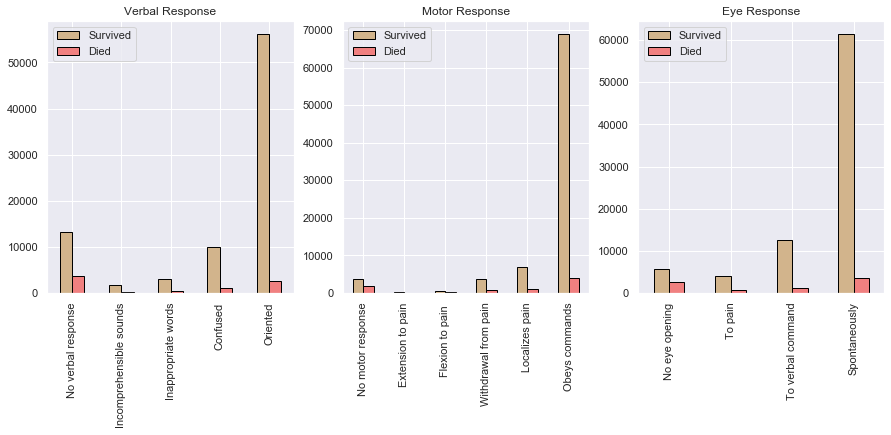

In [35]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
colors=["tan", "lightcoral"]
df_by_int_cat1 = tr_data.groupby(['hospital_death','gcs_verbal_apache']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['hospital_death'],  index = "gcs_verbal_apache",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[0])
x_verble_labels = ('No verbal response', 'Incomprehensible sounds', 'Inappropriate words', 'Confused', 'Oriented')
axes[0].set_xticklabels(x_verble_labels)
axes[0].set_xlabel('')
axes[0].set_title("Verbal Response")
axes[0].legend(('Survived', 'Died'))
df_by_int_cat2 = tr_data.groupby(['hospital_death','gcs_motor_apache']).size().reset_index(name='Count')
df_by_int_cat_pivot2 = pd.pivot_table(df_by_int_cat2,  values='Count',  columns=['hospital_death'],  index = "gcs_motor_apache",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot2.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[1])
x_motor_labels = ('No motor response', 'Extension to pain', 'Flexion to pain ', 'Withdrawal from pain', 'Localizes pain', 'Obeys commands' )
axes[1].set_xticklabels(x_motor_labels)
axes[1].set_xlabel("")
axes[1].set_title("Motor Response")
axes[1].legend(('Survived', 'Died'))
df_by_int_cat3 = tr_data.groupby(['hospital_death','gcs_eyes_apache']).size().reset_index(name='Count')
df_by_int_cat_pivot3 = pd.pivot_table(df_by_int_cat3,  values='Count',  columns=['hospital_death'],  index = "gcs_eyes_apache",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot3.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[2])
x_eye_labels = ('No eye opening', 'To pain', 'To verbal command', 'Spontaneously')
axes[2].set_xticklabels(x_eye_labels)
axes[2].set_xlabel("")
axes[2].set_title("Eye Response")
axes[2].legend(('Survived', 'Died'))

plt.show()

In [36]:
del df_by_int_cat1, df_by_int_cat_pivot1,df_by_int_cat2, df_by_int_cat_pivot2,df_by_int_cat3, df_by_int_cat_pivot3
gc.collect()

44

#### Apache  Death Probability for  ICU and Hospital

The graphs below only show death probabilities for those greater than .05 so that we can compare the distributions between those that survived and those that died.

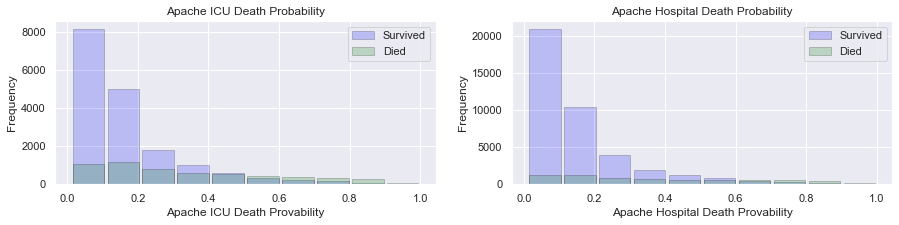

In [37]:
apache_data=tr_data.loc[(tr_data["apache_4a_icu_death_prob"]>.05)]
apache_data2=tr_data.loc[(tr_data["apache_4a_hospital_death_prob"]>.05)]

fig, axes = plt.subplots(1,2, figsize=(15, 3))
bins = np.linspace(.01, 1, 11)

apache_data.loc[apache_data["hospital_death"]==0, "apache_4a_icu_death_prob" ].plot.hist(bins = bins, rwidth=0.9, title='Apache ICU Death Probability', edgecolor='black', alpha=0.2, color="blue", ax = axes[0])
apache_data.loc[apache_data["hospital_death"]!=0, "apache_4a_icu_death_prob" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[0])
axes[0].set_xlabel("Apache ICU Death Provability")
axes[0].legend(('Survived', 'Died'))

apache_data2.loc[apache_data2["hospital_death"]==0, "apache_4a_hospital_death_prob" ].plot.hist(bins = bins, rwidth=0.9, title='Apache Hospital Death Probability', edgecolor='black', alpha=0.2, color="blue", ax = axes[1])
apache_data2.loc[apache_data2["hospital_death"]!=0, "apache_4a_hospital_death_prob" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[1])
axes[1].set_xlabel("Apache Hospital Death Provability")
axes[1].legend(('Survived', 'Died'))

plt.show()


In [38]:
del apache_data, apache_data2
gc.collect()

9092

#### Age and Length of Stay in ICU

Diabetes mellitus (DM) describes a group of metabolic diseases that are characterized by chronic hyperglycemia (elevated blood glucose levels). The two most common forms are type 1 and type 2 diabetes mellitus.

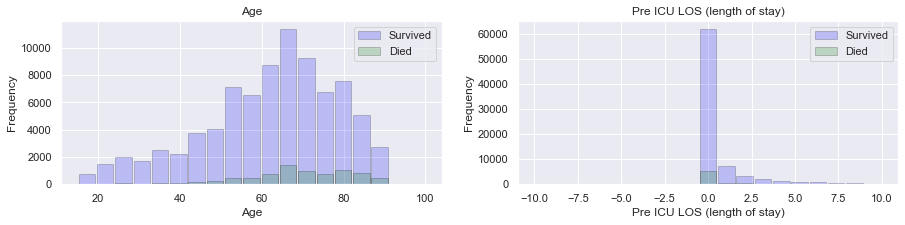

In [39]:
pre_icu=tr_data.loc[(tr_data["pre_icu_los_days"]>0)]
#pre_icu=tr_data.loc[(tr_data["apache_4a_hospital_death_prob"]>.05)]

fig, axes = plt.subplots(1,2, figsize=(15, 3))
bins = np.linspace(15, 100, 20)

tr_data.loc[tr_data["hospital_death"]==0, "age" ].plot.hist(bins = bins, rwidth=0.9, title='Age', edgecolor='black', alpha=0.2, color="blue", ax = axes[0])
tr_data.loc[tr_data["hospital_death"]!=0, "age" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[0])
axes[0].set_xlabel("Age")
axes[0].legend(('Survived', 'Died'))

bins = np.linspace(-10, 10, 20)
pre_icu.loc[pre_icu["hospital_death"]==0, "pre_icu_los_days" ].plot.hist(bins = bins, rwidth=0.9, title='Pre ICU LOS (length of stay)', edgecolor='black', alpha=0.2, color="blue", ax = axes[1])
pre_icu.loc[pre_icu["hospital_death"]!=0, "pre_icu_los_days" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[1])
axes[1].set_xlabel("Pre ICU LOS (length of stay)")
axes[1].legend(('Survived', 'Died'))

plt.show()


#### APACHE scores for  Resprate

The respiratory rate (Breaths per minute) measured during the first 24 hours which results in the highest APACHE III score

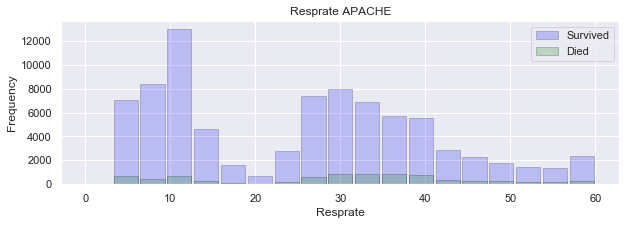

In [40]:
fig, axes = plt.subplots(1,1, figsize=(10, 3))

bins = np.linspace(0, 60, 20)
tr_data.loc[tr_data["hospital_death"]==0, "resprate_apache" ].plot.hist(bins = bins, rwidth=0.9, title='Resprate APACHE', edgecolor='black', alpha=0.2, color="blue", ax = axes)
tr_data.loc[tr_data["hospital_death"]!=0, "resprate_apache" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes)
axes.set_xlabel("Resprate")
axes.legend(('Survived', 'Died'))

plt.show()

#### Peripheral Oxygen Saturation - min and max for the first 24 hours

SpO2 stands for peripheral capillary oxygen saturation, an estimate of the amount of oxygen in the blood.

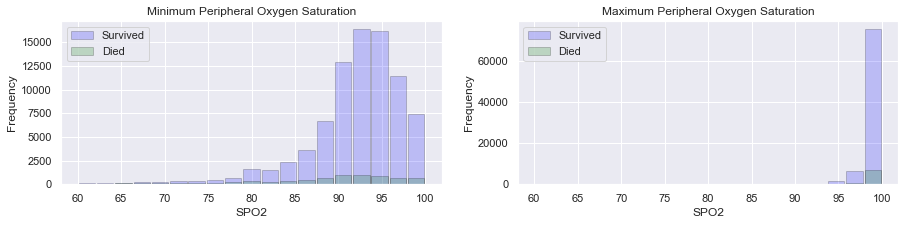

In [41]:
fig, axes = plt.subplots(1,2, figsize=(15, 3))
bins = np.linspace(60, 100, 20)

tr_data.loc[tr_data["hospital_death"]==0, "d1_spo2_min" ].plot.hist(bins = bins, rwidth=0.9, title='Minimum Peripheral Oxygen Saturation', edgecolor='black', alpha=0.2, color="blue", ax = axes[0])
tr_data.loc[tr_data["hospital_death"]!=0, "d1_spo2_min" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[0])
axes[0].set_xlabel("SPO2")
axes[0].legend(('Survived', 'Died'))

bins = np.linspace(60, 100, 20)
tr_data.loc[tr_data["hospital_death"]==0, "d1_spo2_max" ].plot.hist(bins = bins, rwidth=0.9, title='Maximum Peripheral Oxygen Saturation', edgecolor='black', alpha=0.2, color="blue", ax = axes[1])
tr_data.loc[tr_data["hospital_death"]!=0, "d1_spo2_max" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[1])
axes[1].set_xlabel("SPO2")
axes[1].legend(('Survived', 'Died'))

plt.show()

#### Peripheral Oxygen Saturation - min and max for the first  hour

SpO2 stands for peripheral capillary oxygen saturation, an estimate of the amount of oxygen in the blood.

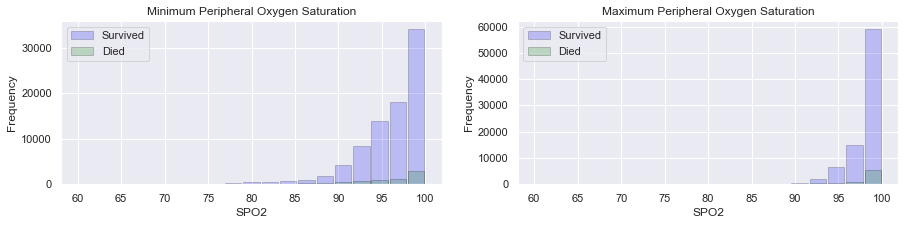

In [42]:
fig, axes = plt.subplots(1,2, figsize=(15, 3))
bins = np.linspace(60, 100, 20)

tr_data.loc[tr_data["hospital_death"]==0, "h1_spo2_min" ].plot.hist(bins = bins, rwidth=0.9, title='Minimum Peripheral Oxygen Saturation', edgecolor='black', alpha=0.2, color="blue", ax = axes[0])
tr_data.loc[tr_data["hospital_death"]!=0, "h1_spo2_min" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[0])
axes[0].set_xlabel("SPO2")
axes[0].legend(('Survived', 'Died'))

bins = np.linspace(60, 100, 20)
tr_data.loc[tr_data["hospital_death"]==0, "h1_spo2_max" ].plot.hist(bins = bins, rwidth=0.9, title='Maximum Peripheral Oxygen Saturation', edgecolor='black', alpha=0.2, color="blue", ax = axes[1])
tr_data.loc[tr_data["hospital_death"]!=0, "h1_spo2_max" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[1])
axes[1].set_xlabel("SPO2")
axes[1].legend(('Survived', 'Died'))

plt.show()

#### Respiration Rate- min and max for the first hour

The highest and lowest The patient's lowest respiratory rate during the first hour of their unit stay

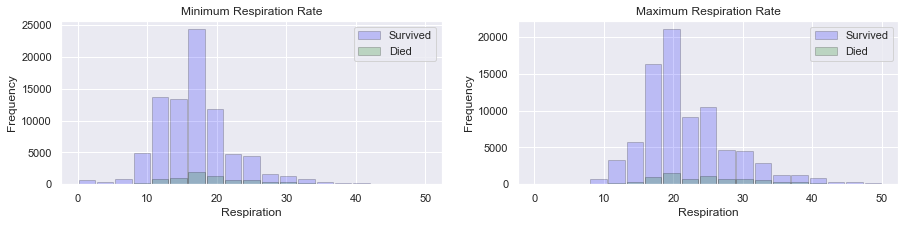

In [43]:
fig, axes = plt.subplots(1,2, figsize=(15, 3))
bins = np.linspace(0, 50, 20)

tr_data.loc[tr_data["hospital_death"]==0, "h1_resprate_min" ].plot.hist(bins = bins, rwidth=0.9, title='Minimum Respiration Rate', edgecolor='black', alpha=0.2, color="blue", ax = axes[0])
tr_data.loc[tr_data["hospital_death"]!=0, "h1_resprate_min" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[0])
axes[0].set_xlabel("Respiration")
axes[0].legend(('Survived', 'Died'))

bins = np.linspace(0, 50, 20)
tr_data.loc[tr_data["hospital_death"]==0, "h1_resprate_max" ].plot.hist(bins = bins, rwidth=0.9, title='Maximum Respiration Rate', edgecolor='black', alpha=0.2, color="blue", ax = axes[1])
tr_data.loc[tr_data["hospital_death"]!=0, "h1_resprate_max" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[1])
axes[1].set_xlabel("Respiration")
axes[1].legend(('Survived', 'Died'))

plt.show()

#### Blood Urea Nitrogen Concentration- min and max for the first 24 hours

The lowest and highest blood urea nitrogen concentration of the patient in their serum or plasma during the first 24 hours of their unit stay

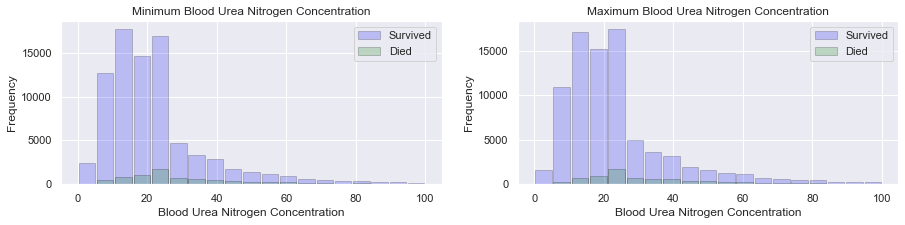

In [44]:
fig, axes = plt.subplots(1,2, figsize=(15, 3))
bins = np.linspace(0, 100, 20)

tr_data.loc[tr_data["hospital_death"]==0, "d1_bun_min" ].plot.hist(bins = bins, rwidth=0.9, title='Minimum Blood Urea Nitrogen Concentration', edgecolor='black', alpha=0.2, color="blue", ax = axes[0])
tr_data.loc[tr_data["hospital_death"]!=0, "d1_bun_min" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[0])
axes[0].set_xlabel("Blood Urea Nitrogen Concentration")
axes[0].legend(('Survived', 'Died'))

bins = np.linspace(0, 100, 20)
tr_data.loc[tr_data["hospital_death"]==0, "d1_bun_max" ].plot.hist(bins = bins, rwidth=0.9, title='Maximum Blood Urea Nitrogen Concentration', edgecolor='black', alpha=0.2, color="blue", ax = axes[1])
tr_data.loc[tr_data["hospital_death"]!=0, "d1_bun_max" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[1])
axes[1].set_xlabel("Blood Urea Nitrogen Concentration")
axes[1].legend(('Survived', 'Died'))

plt.show()

#### Tempature- min and max for the first 24 hours

The patient's lowest and highest core temperature during the first 24 hours of their unit stay

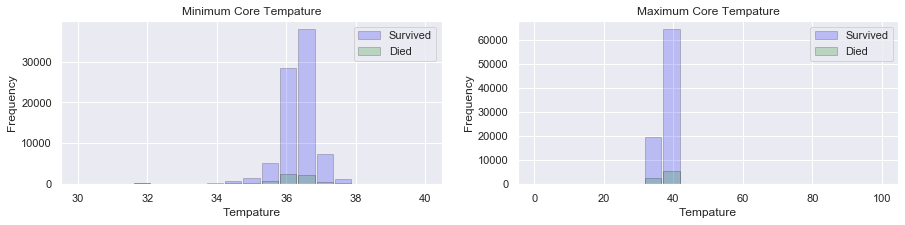

In [45]:
fig, axes = plt.subplots(1,2, figsize=(15, 3))
bins = np.linspace(30, 40, 20)

tr_data.loc[tr_data["hospital_death"]==0, "d1_temp_min" ].plot.hist(bins = bins, rwidth=0.9, title='Minimum Core Tempature', edgecolor='black', alpha=0.2, color="blue", ax = axes[0])
tr_data.loc[tr_data["hospital_death"]!=0, "d1_temp_min" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[0])
axes[0].set_xlabel("Tempature")
axes[0].legend(('Survived', 'Died'))

bins = np.linspace(0, 100, 20)
tr_data.loc[tr_data["hospital_death"]==0, "d1_temp_max" ].plot.hist(bins = bins, rwidth=0.9, title='Maximum Core Tempature', edgecolor='black', alpha=0.2, color="blue", ax = axes[1])
tr_data.loc[tr_data["hospital_death"]!=0, "d1_temp_max" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[1])
axes[1].set_xlabel("Tempature")
axes[1].legend(('Survived', 'Died'))

plt.show()

#### Respiratory Rate- min and max for the first 24  hours

The patient's lowest respiratory rate during the first 24 hours of their unit stay

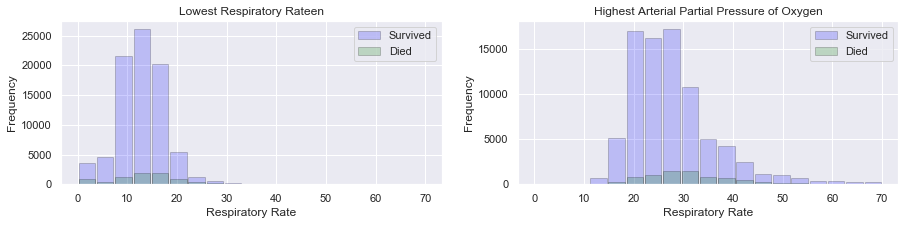

In [46]:
fig, axes = plt.subplots(1,2, figsize=(15, 3))
bins = np.linspace(0, 70, 20)

tr_data.loc[tr_data["hospital_death"]==0, "d1_resprate_min" ].plot.hist(bins = bins, rwidth=0.9, title='Lowest Respiratory Rateen', edgecolor='black', alpha=0.2, color="blue", ax = axes[0])
tr_data.loc[tr_data["hospital_death"]!=0, "d1_resprate_min" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[0])
axes[0].set_xlabel("Respiratory Rate")
axes[0].legend(('Survived', 'Died'))

bins = np.linspace(0, 70, 20)
tr_data.loc[tr_data["hospital_death"]==0, "d1_resprate_max" ].plot.hist(bins = bins, rwidth=0.9, title='Highest Arterial Partial Pressure of Oxygen', edgecolor='black', alpha=0.2, color="blue", ax = axes[1])
tr_data.loc[tr_data["hospital_death"]!=0, "d1_resprate_max" ].plot.hist(bins = bins, rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes[1])
axes[1].set_xlabel("Respiratory Rate")
axes[1].legend(('Survived', 'Died'))

plt.show()

#### Ventilated or Intubated

Ventilated: Whether the patient was invasively ventilated  at the time of the highest scoring arterial blood gas using the oxygenation scoring algorithm, including any mode of positive pressure ventilation delivered through a circuit attached to an endo-tracheal tube or tracheostomy.

Intubated: Whether the patient was intubated at the time of the highest scoring arterial blood gas used in the oxygenation score

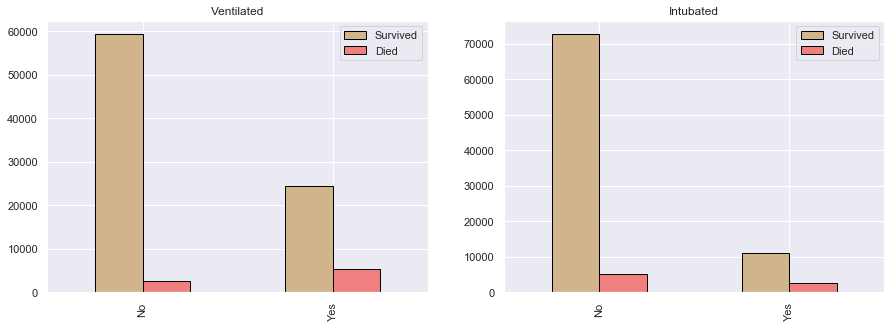

In [47]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
colors=["tan", "lightcoral"]
df_by_int_cat1 = tr_data.groupby(['hospital_death','ventilated_apache']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['hospital_death'],  index = "ventilated_apache",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[0])
x_verble_labels = ('No', 'Yes')
axes[0].set_xticklabels(x_verble_labels)
axes[0].set_xlabel('')
axes[0].set_title("Ventilated")
axes[0].legend(('Survived', 'Died'))
df_by_int_cat2 = tr_data.groupby(['hospital_death','intubated_apache']).size().reset_index(name='Count')
df_by_int_cat_pivot2 = pd.pivot_table(df_by_int_cat2,  values='Count',  columns=['hospital_death'],  index = "intubated_apache",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot2.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[1])
x_motor_labels =('No', 'Yes')
axes[1].set_xticklabels(x_motor_labels)
axes[1].set_xlabel("")
axes[1].set_title("Intubated")
axes[1].legend(('Survived', 'Died'))

plt.show()

#### Diabetes

Whether the patient has been diagnosed with diabetes, either juvenile or adult onset, which requires medication.

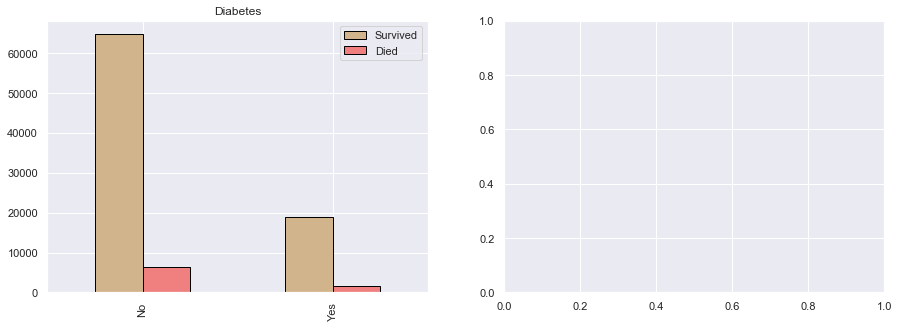

In [48]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
colors=["tan", "lightcoral"]
df_by_int_cat1 = tr_data.groupby(['hospital_death','diabetes_mellitus']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['hospital_death'],  index = "diabetes_mellitus",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[0])
x_verble_labels = ('No', 'Yes')
axes[0].set_xticklabels(x_verble_labels)
axes[0].set_xlabel('')
axes[0].set_title("Diabetes")
axes[0].legend(('Survived', 'Died'))


plt.show()

#### Gender

The genotypical sex of the patient.

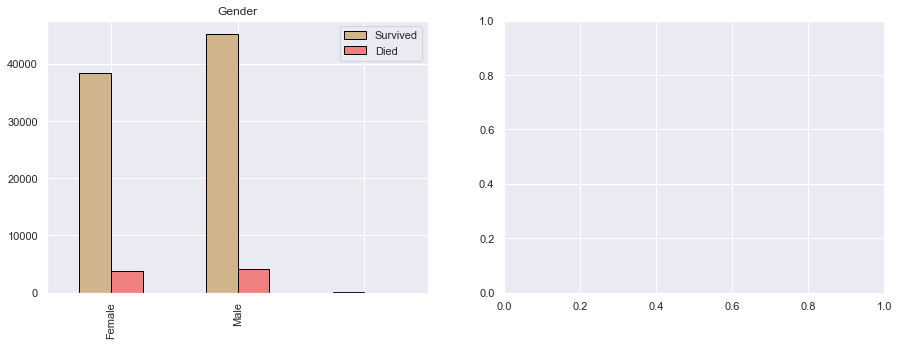

In [49]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
colors=["tan", "lightcoral"]
df_by_int_cat1 = tr_data.groupby(['hospital_death','gender']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['hospital_death'],  index = "gender",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[0])
x_verble_labels = ('Female','Male' )
axes[0].set_xticklabels(x_verble_labels)
axes[0].set_xlabel('')
axes[0].set_title("Gender")
axes[0].legend(('Survived', 'Died', 'NA'))


plt.show()

#### Hospital and ICU Admit Source

The location of the patient prior to being admitted to the hospital or ICU.

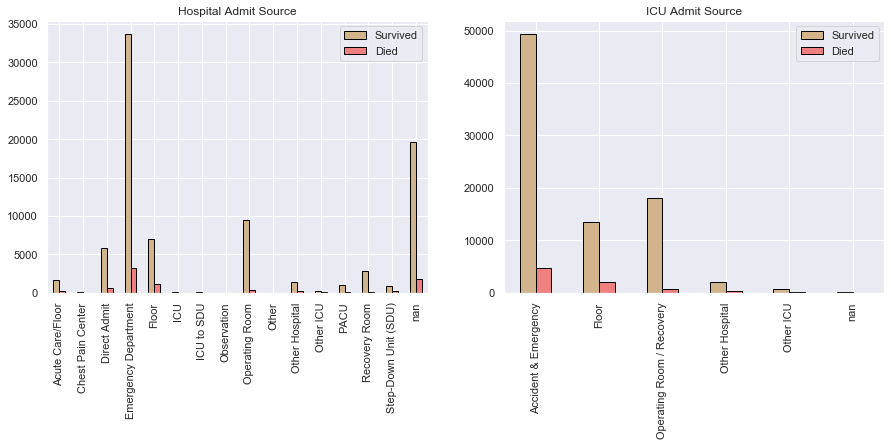

In [50]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
colors=["tan", "lightcoral"]
df_by_int_cat1 = tr_data.groupby(['hospital_death','hospital_admit_source']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['hospital_death'],  index = "hospital_admit_source",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[0])
axes[0].set_xlabel('')
axes[0].set_title("Hospital Admit Source")
axes[0].legend(('Survived', 'Died'))

df_by_int_cat1 = tr_data.groupby(['hospital_death','icu_admit_source']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['hospital_death'],  index = "icu_admit_source",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[1])
axes[1].set_xlabel('')
axes[1].set_title("ICU Admit Source")
axes[1].legend(('Survived', 'Died'))


plt.show()

#### ICU Type and Ethnicity

ICU Type: A classification which indicates the type of care the unit is capable of providing


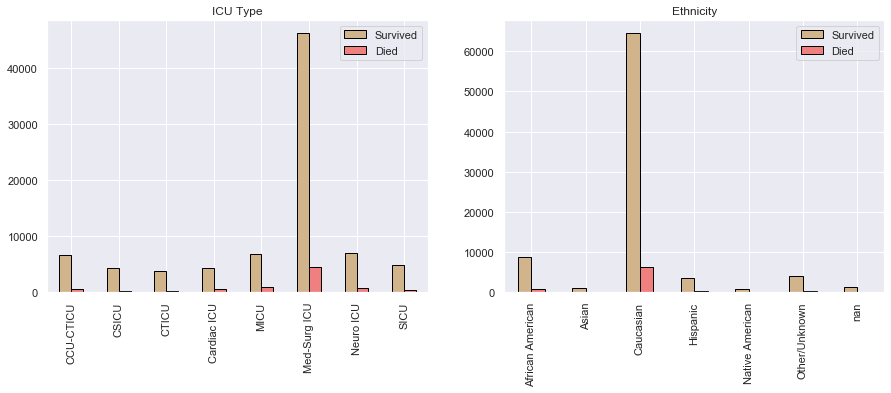

In [51]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
colors=["tan", "lightcoral"]
df_by_int_cat1 = tr_data.groupby(['hospital_death','icu_type']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['hospital_death'],  index = "icu_type",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[0])
axes[0].set_xlabel('')
axes[0].set_title("ICU Type")
axes[0].legend(('Survived', 'Died'))

df_by_int_cat1 = tr_data.groupby(['hospital_death','ethnicity']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['hospital_death'],  index = "ethnicity",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[1])
axes[1].set_xlabel('')
axes[1].set_title("Ethnicity")
axes[1].legend(('Survived', 'Died'))


plt.show()

### Distribution our target variable

 Whether the patient died during this hospitalization

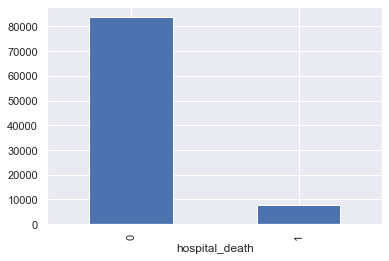

In [52]:

tr_data.groupby(['hospital_death']).size().plot.bar()
plt.show()

In [53]:
tr_data.shape

(91713, 138)

### Prepare Data for Modeling

#### Separate Target Variable

In [55]:
target_label='hospital_death'
X = tr_data.drop([target_label], axis=1)
y = tr_data[target_label]

X_ul = ul_data.drop([target_label], axis=1)
    
del tr_data, ul_data
gc.collect()    

46145

#### Split Columns into two Lists

String/category columns will be encoded and numeric columns will be scaled.

In [56]:

columns_to_encode = [col for col in X.columns if X[col].dtypes == 'object']
columns_to_scale  = [col for col in X.columns if X[col].dtypes != 'object']

#### Convert appropriate features to type object

In [57]:

train_columns = [x for x in X.columns if x not in ['encounter_id','patient_id','hospital_death','readmission_status']]

categorical_features = []
for m in train_columns:
    if(X[m].dtypes=='object'):
        categorical_features.append(m)

        
categorical_index = [train_columns.index(x) for x in categorical_features]


#### One Hot Encode or Label Encode the Data

In [58]:

X_encoded_columns,X_ul_encoded_columns = categorical_encode (X, X_ul,  columns_to_encode)

# Label Encoding
# lbl = LabelEncoder()
# for f in columns_to_encode:
#     if X[f].dtype == 'object': 
#         lbl.fit(list(X[f].values) + list(X_ul[f].values))
#         X[f] = lbl.transform(list(X[f].values))
#         X_ul[f] = lbl.transform(list(X_ul[f].values))   

#### Scale the Data

The following will standardize the dataset (center to the mean and component wise scale to unit variance.) The alternative method would be to use a min max scaler.

In [59]:
# Fit to the training data only, not to the unlabled dataset
scaler = StandardScaler()
scaler.fit(X[columns_to_scale] )

# Apply the scaler.
X_scaled_columns   = pd.DataFrame(scaler.transform(X[columns_to_scale] ), columns = X[columns_to_scale].columns)
X_ul_scaled_columns = pd.DataFrame(scaler.transform(X_ul[columns_to_scale] ),columns = X_ul[columns_to_scale].columns )

In [60]:
#from sklearn.preprocessing import Normalizer
#transformer = Normalizer().fit(X[columns_to_scale])

#X_scaled_columns   = pd.DataFrame(transformer.transform(X[columns_to_scale] ), columns = X[columns_to_scale].columns)
#X_ul_scaled_columns = pd.DataFrame(transformer.transform(X_ul[columns_to_scale] ),columns = X_ul[columns_to_scale].columns )

#### Join Encoded Data with Scaled Data


In [61]:
X= pd.concat([X_scaled_columns, X_encoded_columns], axis=1)
X_ul= pd.concat([X_ul_scaled_columns, X_ul_encoded_columns], axis=1)
columns= X.columns

#### Split the Data into Train/Test

We will split our newly vectorized data into 80% train and 20% test. Our random state value will ensure that the data is split the same way each time so that we can replicate results. 

In [62]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=22)

### Train the LightGBM Model

The parameters below were tweaked quie a bit before setteling on what is included below. 

In [63]:
Perform_LGBM=True
if Perform_LGBM:
    params_new = {'task': 'train',
         'boosting': 'gbdt',
         'objective':'binary',
         'metric': 'auc',
         'num_leaves': 15,
         'min_data_in_leaf': 90,
         'learning_rate': 0.01,
         'max_depth': 5,
         'feature_fraction': 0.1,
         'bagging_freq': 1,
         'bagging_fraction': 0.75,
         'use_missing': True,
         'nthread': 4
        }
    
    NFOLDS = 5
    folds = KFold(n_splits=NFOLDS)

    X=  pd.DataFrame(x_train, columns=columns)
    y=  pd.Series(y_train)

    x_test=  pd.DataFrame(x_test, columns=columns)
    y_test=  pd.Series(y_test)

    splits = folds.split(X, y)
    #y_preds = np.zeros(X_test.shape[0])
    y_oof = np.zeros(X.shape[0])
    score = 0
    aucs = list()
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = columns

    sm = SMOTE(random_state=42)
    
    #Using Cross Validation, Build LGBM Classifiers:
    for fold_n, (train_index, valid_index) in enumerate(splits):
        print('Training on fold {}'.format(fold_n + 1))
    
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        Y_train, Y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    
        #X_bal_train, Y_bal_train = sm.fit_sample(X_train, Y_train)
        X_bal_train=X_train
        Y_bal_train=Y_train
        
        dtrain = lgb.Dataset(X_bal_train, label=Y_bal_train)
        dvalid = lgb.Dataset(X_valid, label=Y_valid)

        clf = lgb.train(params_new, dtrain, num_boost_round=7000, valid_sets = [dtrain, dvalid], verbose_eval=100, early_stopping_rounds=100)
        
        
        # feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        aucs.append(clf.best_score['valid_1']['auc'])
    
        del X_train,X_bal_train, X_valid, Y_train,Y_bal_train, Y_valid
        gc.collect()
        
    # clf right now is the last model, trained with 80% of data and validated with 20%
    print(f"\nMean AUC = {np.mean(aucs)}")
    best_iter = clf.best_iteration
    #X_bal, Y_bal = sm.fit_sample(X, y)
    X_bal_train=X
    Y_bal_train=y
    

Training on fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.889254	valid_1's auc: 0.869568
[200]	training's auc: 0.89629	valid_1's auc: 0.876029
[300]	training's auc: 0.901362	valid_1's auc: 0.880332
[400]	training's auc: 0.905369	valid_1's auc: 0.883104
[500]	training's auc: 0.908903	valid_1's auc: 0.885631
[600]	training's auc: 0.911946	valid_1's auc: 0.88728
[700]	training's auc: 0.91477	valid_1's auc: 0.888689
[800]	training's auc: 0.917336	valid_1's auc: 0.889769
[900]	training's auc: 0.919645	valid_1's auc: 0.890665
[1000]	training's auc: 0.921829	valid_1's auc: 0.891484
[1100]	training's auc: 0.923804	valid_1's auc: 0.892084
[1200]	training's auc: 0.92573	valid_1's auc: 0.892644
[1300]	training's auc: 0.927502	valid_1's auc: 0.893189
[1400]	training's auc: 0.929104	valid_1's auc: 0.893618
[1500]	training's auc: 0.930735	valid_1's auc: 0.893886
[1600]	training's auc: 0.932291	valid_1's auc: 0.894223
[1700]	training's auc: 0.933715	vali

Confusion Matrix
[[16584   182]
 [ 1020   557]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     16766
           1       0.75      0.35      0.48      1577

    accuracy                           0.93     18343
   macro avg       0.85      0.67      0.72     18343
weighted avg       0.93      0.93      0.92     18343

Accuracy Score 0.9344709153355504


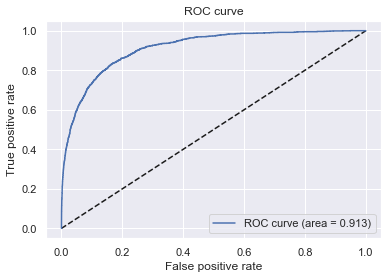

AUC 0.9125334502875231


In [64]:
    lgb_clf = lgb.LGBMClassifier(**params_new, num_boost_round=best_iter)
    lgb_clf.fit(X_bal_train, Y_bal_train)
    predict_evaluate(x_test, y_test, lgb_clf) 

### Create file for submission

In [69]:
yhat_ul = lgb_clf.predict_proba(X_ul)
submit_data = pd.read_csv("solution_template.csv")
submit_data['hospital_death']=yhat_ul[:, 1]
submit_data[["encounter_id", "hospital_death"]].to_csv("submission.csv",index=False)


### Score and Summary

#### Kaggle generated AUC Score 

When I upload probability predictions for the unlabeled data (the most recently created submission.csv file to Kaggle), the AUC scores come back as the follows;

Private: 0.90487 | Public: 0.90828

This score would have put us at the 168 position (out of 951) on the public leaderboard.
Unfortunately, the competition closed a week ago and the best scores I was able to generate before the closing was the following, (which put us at 244 out of 951).

Private: 0.90443 |Public: 0.90628

<b>Summary:</b>
As can be seen from the other companion notebook to this one (called "WiSD Kaggle Condensed Stacked" (Coming Soon) - where I train many models and then attempt to stack or blend them to improve upon this score), I was (surprisingly) not able to improve upon the lone LightGBM model. Ultimately I did achieve an AUC on my test data that was an improvement on this model, but, because of some overfitting that I could not find, the resulting AUC scores on the unlabeled data (according to Kaggle) was not as high as the one from this model.

My plan is to compare other examples of model stacking and/or blending to see if there is an error in my code that led to overfitting. If I do find this, I will modify my code and add notes to the notebook named "WiSD Kaggle Condensed Stacked".